# Analyse data for line loop navigation coming from the homecage 

In [447]:
%matplotlib inline

import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import scipy.stats as stt
import pandas as pd
from datetime import datetime
from functools import partial
import matplotlib
import networkx as nx
import seaborn

seaborn.set(font_scale=1.5,style='ticks')


In [448]:
#physical positions of the pokes
poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

##  Main function to analyse probe trial performance

In [449]:
df = pd.DataFrame(columns=['subject','time','seq','graph_type','two_tasks','nRews','probe_dict'])

In [450]:
def get_experiment_name(line):
    return re.findall('Experiment name[\s] \: (.*)\n',line)[0]

def get_subject_name(line):
    return re.findall('Subject ID[\s]:[\s](.*)\n',line)[0]

def get_start_date(line):
    return re.findall('Start date[\s]:[\s](.*)\n',line)[0]

In [451]:
def get_probe_trial_performance_homecage(lines):
    """ 
        Takes in lines output by pycontrol and returns a dict that contains probe trial
        performance for each transition
    
    
        Arguments:
        ===========================
        lines (list of str):             output of pycontrol
        
        Returns:
        ==========================
        all_info_dicts (list of dicts):  a list of dicts where each entry in the list
                                         is a dict containing whether probe trials were
                                         correct for each transition. If more than 1 graph
                                         was explored in a given session, then the performance
                                         then this list will have more than 1 dict in it. Other
                                         wise it will only have one
        
        
    """
    times = []
    probe_perf = []
    target_hist = []; probe_hist = []; poked_hist = []; dir_hist = []; seq_hist = []

    task_nums = []
    info_dict = {}
    probe_dict = {}
    all_info_dicts = [] #this is for when there are two tasks in one session
    seq = None
    task_number = None
    n_rewards = np.nan
    #iterate over flines
    for ix,l_ in enumerate(lines[:-1]):
        
        
        #find basic task metadata
        if 'Subject ID' in l_: info_dict['subject'] = get_subject_name(l_)
        if 'Experiment name' in l_: info_dict['exp_name'] = get_experiment_name(l_)
        if 'Start date' in l_: info_dict['date'] = get_start_date(l_)
            
        
        if 'task_number' in l_:
            
            #if there is already one task then store the info for the
            #'completed' task here and perform some cleanup
            if len(task_nums)>0:
                info_dict['seq'] = seq
                info_dict['task_nr'] = task_number
                info_dict['probe_dict'] = probe_dict.copy()
                info_dict['len_seq'] = None if seq is None else len(seq)
                all_info_dicts.append(info_dict.copy())
                info_dict = info_dict.copy()
                del info_dict['probe_dict']
                probe_dict = {}
            task_number = int(re.findall('task_number([0-9])',l_)[0])
            task_nums.append(task_number)
        
        #store the sequence that was explored
        if 'seq' in l_:
            seq = eval(re.findall('seq:(\[.*\])', l_)[0])
            
        #process the print-lines that describe the subjects behaviour
        if 'TARGET:' in l_:  
            t_ = re.findall('P ([0-9]*) R',l_)[0]
            times.append(float(t_))
            probe = eval(re.findall('PROBE: (False|True)',l_)[0])
            target = int(re.findall('TARGET: ([0-9]*)',l_)[0])
            poked = int(re.findall('POKED: ([0-9]*)',l_)[0])
            direction = int(re.findall('DIR: (.*)',l_)[0])
            seq_ix = int(re.findall('SEQ_IX: ([0-9]*)',l_)[0])
            if seq_hist:
                if probe:
                    
                    if not (probe_hist[-1] and (target==target_hist[-1])) and ((times[-1]-times[-2])<2000):
                        correct_poke = poked==target
                        probe_perf.append(correct_poke)
                        transition = str(target_hist[-1]) + '_' + str(target)

                        if transition in probe_dict.keys():
                            probe_dict[transition].append(correct_poke)
                        else:
                            probe_dict[transition] = [correct_poke]
                            
                       

            target_hist.append(target); probe_hist.append(probe); dir_hist.append(direction);
            poked_hist.append(poked); seq_hist.append(seq_ix)
    #print(len(probe_perf))
    try:
        n_rewards = float(eval(re.findall('Variables(.*)',lines[-1])[0])['n_rewards'])
    except IndexError:
        n_rewards = np.nan

    info_dict['seq'] = seq; info_dict['task_nr'] = task_number; info_dict['probe_dict'] = probe_dict.copy()
    info_dict['len_seq'] = None if seq is None else len(seq)
    info_dict['n_rewards'] = n_rewards
    all_info_dicts.append(info_dict)
    return all_info_dicts

In [452]:
def build_df(subject_folders):
    """
    Here we loop through the subject folders and get a list of all sessions
    that is annotated with some metadata
    
    Arguments:
    =========================================
    
    subject_folders (list): list of folders where each folder contains the
                            data files for one subject
                            
    
    """
    df = pd.DataFrame(columns=['subject','exp_name', 'date', 'seq', 'task_nr', 'probe_dict', 'len_seq','n_rewards'])
    for ROOT in subject_folders:
        #print(ROOT)
        fs = [i for i in os.listdir(ROOT) if '_taskFile' not in i]
        probe_dict = {}
        for f_ in fs:
            if 'follow_the_light_2_graphs' in f_:
                #print(f_)
                fpath = os.path.join(ROOT,f_)
                with open(fpath,'r') as f:
                    lines = f.readlines()

                all_info_dict = get_probe_trial_performance_homecage(lines)
                #print(probe_dict)
                for i in all_info_dict:
                    df = df.append(i,ignore_index=True)
    return df

In [453]:
def merge_probe_trial_dicts(x,only_last=None):
    """ 
    Function passed as argument to result of pandas groupby in
    order to merge the dicts by subject and task
    
    Arguments:
    =========================
    x: what is passed by agg
    
    only_last (int): only look at the last n probe trials for each transition
    """
    out = {}
    for d in x.dropna():
        for k,v in d.items():
            if k not in out.keys():
                out[k] = v
            else:
                out[k].extend(v)
                
    if only_last:
        for k,v in out.items():
            out[k] = v[-only_last:]
    return out


In [454]:
def make_plot(res_dict,mx=1,color='mean'):
    #plt.figure(figsize=(12,4))


#    mx = 1
    if color=='pval': cmap_ = 'RdYlGn_r'
    else: cmap_ = 'RdYlGn'
    cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=mx,clip=True),cmap=cmap_)

    G0 = nx.DiGraph()
    G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos,color='.3')
    nx.draw(G0,pos=poke_pos,alpha=.2,node_color='.3')


    G = nx.DiGraph()
    for k,v in res_dict.items():
        if color=='pval':
            c = stt.binom_test(np.sum(v),len(v),p=1/9.)
        else:
            c= np.mean(v)
        G.add_edge(int(k[0]),int(k[-1]),color=cmap.to_rgba(c))

    colors = nx.get_edge_attributes(G,'color')

    nx.draw(G,
            pos=poke_pos,edge_color=np.array(list(colors.values())),
            node_color='.3',
            node_size=512,
            connectionstyle="arc3,rad=-0.1",
            width=3
    )


# Run analysis

In [455]:
experiment_folders = ['/Users/yves/Dropbox/pyhomecage/data/ec_lineloop_1/',
                     '/Users/yves/Dropbox/pyhomecage/data/ec_lineloop_2/']

subject_folders = []
for ef in experiment_folders:
    sf1 = os.listdir(ef)
    
    for sf_ in sf1:
        sf = os.path.join(ef,sf_)
        #print(sf)
        #if sf=='/Users/yves/Downloads/ec_lineloop_2/.DS_Store':
        #|print('.DS' in sf)
        if not ('.DS' in sf):
            fold2 = [i for i in os.listdir(sf) if '.DS' not in i][0]
            subject_folders.append(os.path.join(sf,fold2))


In [456]:
df = build_df(subject_folders)
df['date'] = pd.to_datetime(df['date'])

# Plot basic visition stuff

In [457]:
grouped_by_day = df.groupby([pd.Grouper(key='date',freq='D'),'subject'])
gbd_sum =grouped_by_day['n_rewards'].sum()
gbd_dfs = gbd_sum.reset_index()

gbd_mean =grouped_by_day['n_rewards'].mean()
gbd_dfm = gbd_mean.reset_index()

gbd_num =grouped_by_day['n_rewards'].count()
gbd_dfn = gbd_num.reset_index()


#gbd_sum.add_suffix('_Count').reset_index()

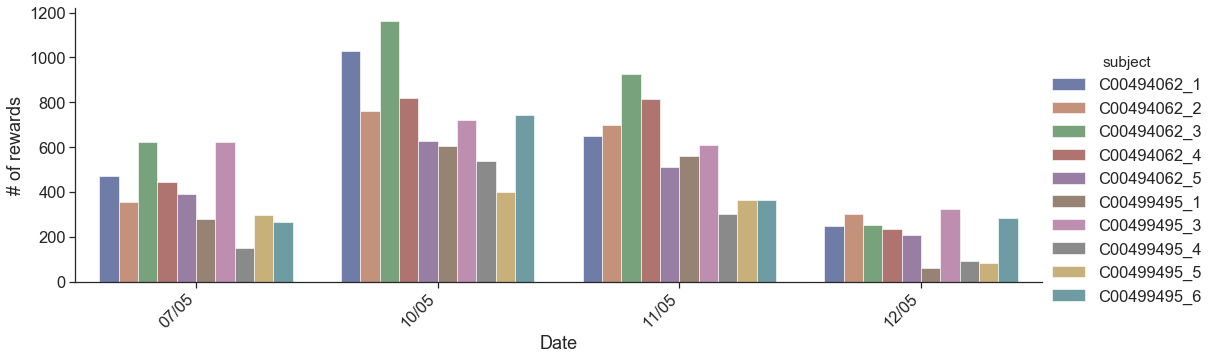

In [458]:
#plt.figure(figsize=(12,3))
g = seaborn.catplot(
    data=gbd_dfs, kind="bar",
    x="date", y="n_rewards", hue="subject",
    ci="sd", palette="dark", alpha=.6, height=5, # make the plot 5 units high
    aspect=3
)


#g.despine(left=True)
g.set_axis_labels("Date", "# of rewards")
x_dates = gbd_df['date'].dt.strftime('%d/%m').sort_values().unique()
_ = plt.gca().set_xticklabels(labels=x_dates, rotation=45, ha='right')

#g.legend.set_title("")


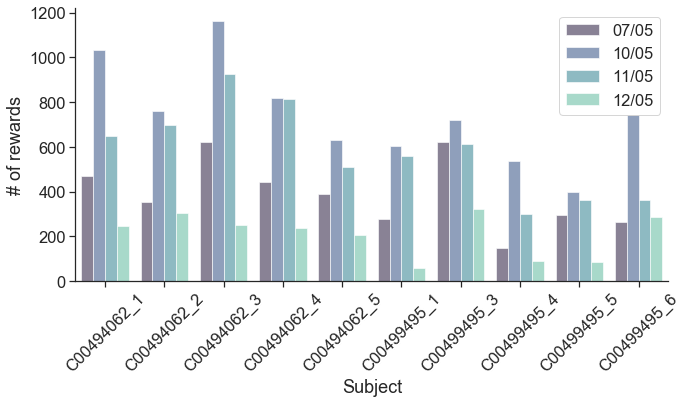

In [459]:
#plt.figure(figsize=(12,3))
g = seaborn.catplot(
    data=gbd_dfs, kind="bar",
    x="subject", y="n_rewards", hue="date",
    ci="sd", alpha=.6, height=5, # make the plot 5 units high
    aspect=2, palette='mako',legend=False
)


#g.despine(left=True)
g.set_axis_labels("Subject", "# of rewards")

g.set_xticklabels(rotation=45)
x_dates = gbd_df['date'].dt.strftime('%d/%m').sort_values().unique()
#_ = plt.gca().set_xticklabels(labels=x_dates, rotation=45, ha='right')
legend = plt.gca().legend()
for l in legend.get_texts():
    l.set_text(datetime.strptime(l.get_text()[:10],'%Y-%m-%d').strftime('%d/%m'))
#g.legend.set_title("")


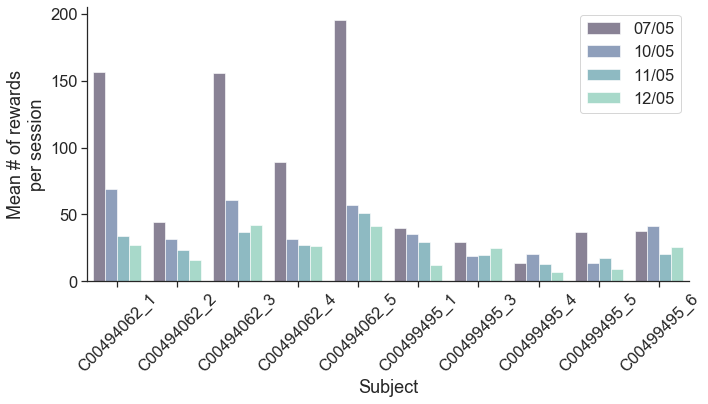

In [460]:
#plt.figure(figsize=(12,3))
g = seaborn.catplot(
    data=gbd_dfm, kind="bar",
    x="subject", y="n_rewards", hue="date",
    ci="sd", alpha=.6, height=5, # make the plot 5 units high
    aspect=2, palette='mako',legend=False
)


#g.despine(left=True)
g.set_axis_labels("Subject", "Mean # of rewards\nper session")

g.set_xticklabels(rotation=45)
x_dates = gbd_df['date'].dt.strftime('%d/%m').sort_values().unique()
#_ = plt.gca().set_xticklabels(labels=x_dates, rotation=45, ha='right')
legend = plt.gca().legend()
for l in legend.get_texts():
    l.set_text(datetime.strptime(l.get_text()[:10],'%Y-%m-%d').strftime('%d/%m'))
#g.legend.set_title("")


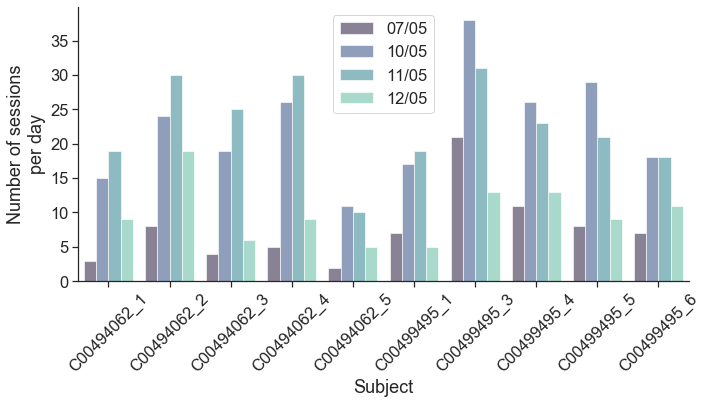

In [461]:
#plt.figure(figsize=(12,3))
g = seaborn.catplot(
    data=gbd_dfn, kind="bar",
    x="subject", y="n_rewards", hue="date",
    ci="sd", alpha=.6, height=5, # make the plot 5 units high
    aspect=2, palette='mako',legend=False
)


#g.despine(left=True)
g.set_axis_labels("Subject", "Number of sessions\nper day")

g.set_xticklabels(rotation=45)
x_dates = gbd_df['date'].dt.strftime('%d/%m').sort_values().unique()
#_ = plt.gca().set_xticklabels(labels=x_dates, rotation=45, ha='right')
legend = plt.gca().legend()
for l in legend.get_texts():
    l.set_text(datetime.strptime(l.get_text()[:10],'%Y-%m-%d').strftime('%d/%m'))
#g.legend.set_title("")


## Make plot showing fraction correct for each transition

In [462]:
grouped= df.groupby(['subject','task_nr'])  #group results by task and subject
mptd_only20 = partial(merge_probe_trial_dicts,only_last=20)  #consider only last 30 probe trials on each transition
mergag = grouped['probe_dict'].agg(mptd_only20)  #aggregate data across sessions using function above

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if c

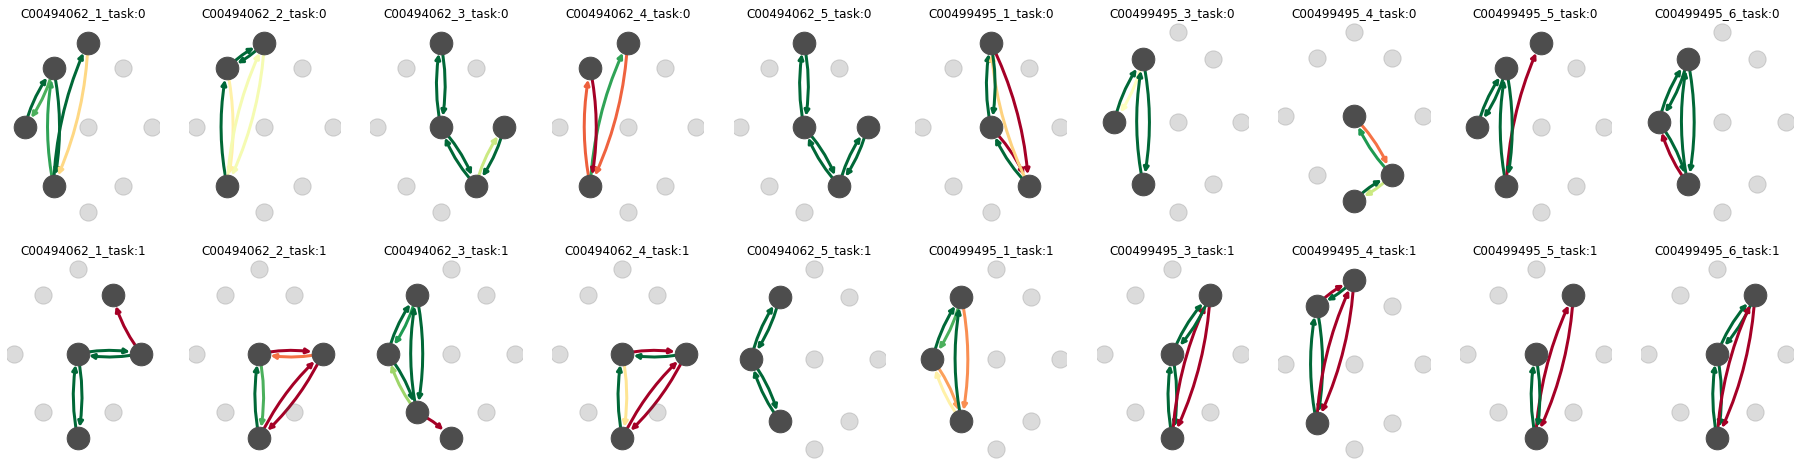

In [186]:
plt.figure(figsize=(32,8))
ctr = 0
subplot_pos = [val+1 for pair in zip(range(10), range(10,20)) for val in pair]

for (subj,task), probe_trials in mergag.iteritems():
    plt.subplot(2,10,subplot_pos[ctr])
    plt.title('_'.join([subj,'task:{}'.format(str(task))]))
    #make_plot(probe_trials,color='pval',mx=0.05)
    make_plot(probe_trials,color='mean',mx=0.4)

    
    ctr+=1

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if c

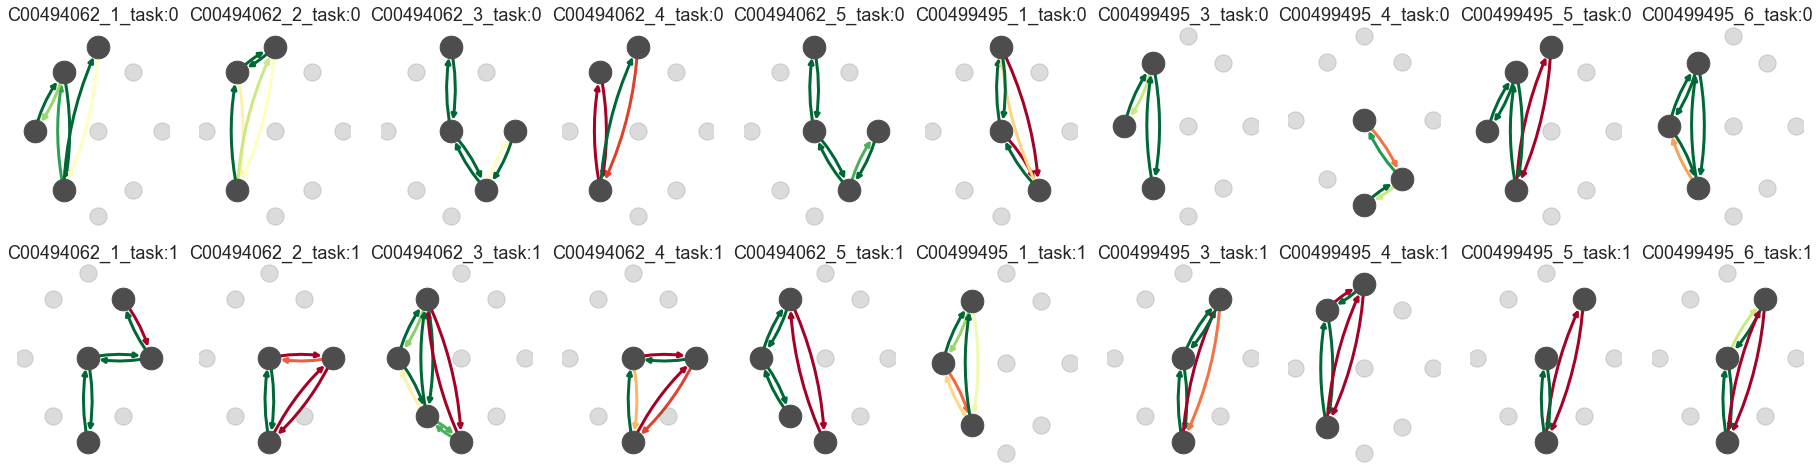

In [463]:
plt.figure(figsize=(32,8))
ctr = 0
subplot_pos = [val+1 for pair in zip(range(10), range(10,20)) for val in pair]

for (subj,task), probe_trials in mergag.iteritems():
    plt.subplot(2,10,subplot_pos[ctr])
    plt.title('_'.join([subj,'task:{}'.format(str(task))]))
    #make_plot(probe_trials,color='pval',mx=0.05)
    
    #plot mean fraction correct on probe trials. Mx specifies
    #what value the color green corresponds to
    make_plot(probe_trials,color='mean',mx=0.4)

    
    ctr+=1

## Make plot showing p-value of performance 

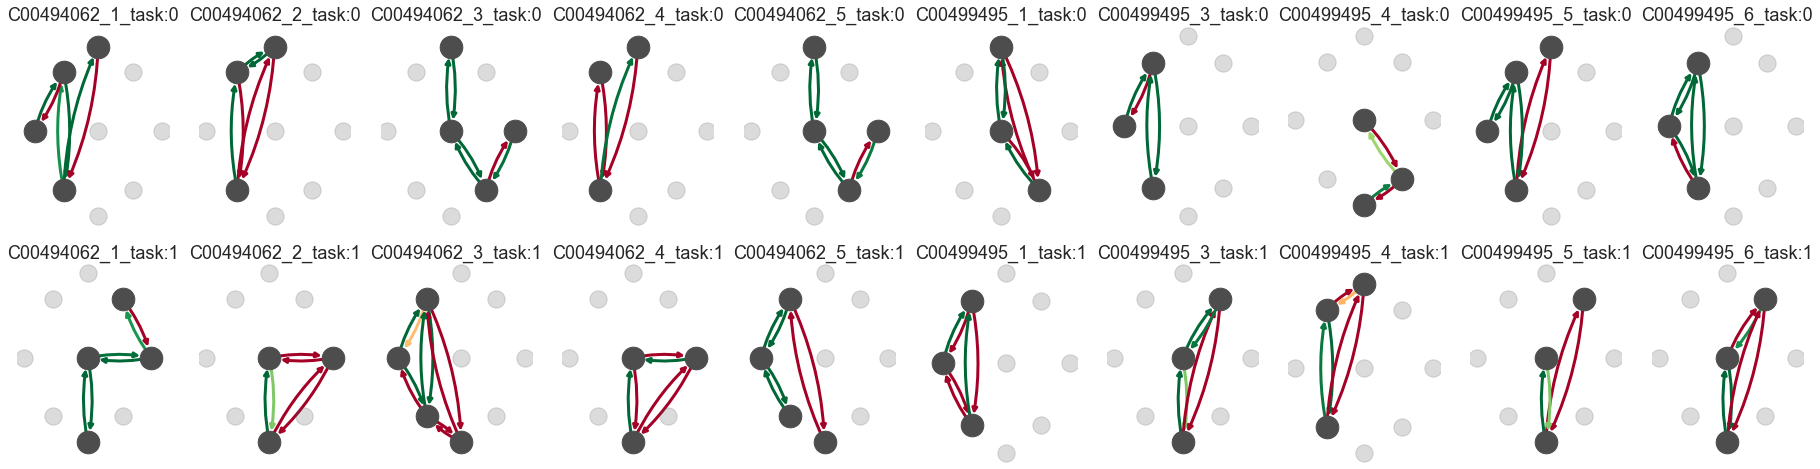

In [466]:
plt.figure(figsize=(32,8))
ctr = 0
subplot_pos = [val+1 for pair in zip(range(10), range(10,20)) for val in pair]

for (subj,task), probe_trials in mergag.iteritems():
    plt.subplot(2,10,subplot_pos[ctr])
    plt.title('_'.join([subj,'task:{}'.format(str(task))]))
    
    #plot p-value (against 1/9) of performance on probe trials.
    #being better than chance. mx specifies what value the color green corresponds to
    make_plot(probe_trials,color='pval',mx=0.05)
    #make_plot(probe_trials,color='mean',mx=0.4)

    
    ctr+=1